<a href="https://colab.research.google.com/github/ashcat2005/lightcurve-exoplanet/blob/main/ExoplanetModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exoplanet Model

---
## Flux Model
Simple model of the flux (without limb darkening). Eq. (1) in reference [1] or Eq. (2.1) in [2].

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def L(p, z):
  '''
  Obstruction function
  '''
  if z>1+p:
    return 0.
  elif (1-p<z and z<=1+p):
    k0 = np.arccos((p**2 + z**2 -1)/(2*p*z))
    k1 = np.arccos((1-p**2 + z**2)/(2*z))
    L0 = k0*p**2
    L2 = np.sqrt((4*z**2- (1+z**2-p**2)**2)/4) 
    return (L0 + k1 - L2)/np.pi
  elif (z>=0. and z<=1-p):
    return p**2
  elif z<= p-1: # Check this option!!
    return 1.

p = 0.1 # Ratio of sizes r_p/r_*

n=100 # Number of points in the grid
z = np.linspace(0.,1.5,n) #Values of the adimensional distance z
F = np.zeros(n) # Flux

# Determine the flux at each value of z
for i in range(n):
  F[i] = 1. - L(p,z[i])


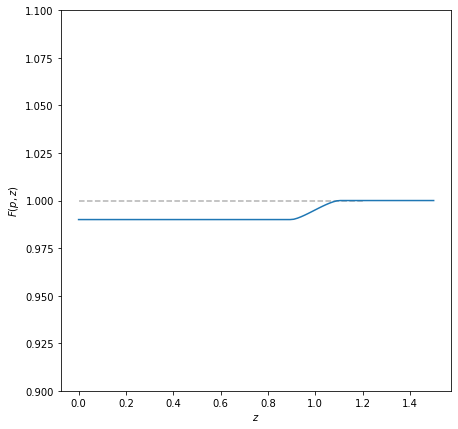

In [4]:
# Plot the Flux as function of z
plt.figure(figsize=(7,7))
plt.plot(z, F)
plt.hlines(1., 0., 1.2,linestyle='dashed', alpha=0.3)
plt.ylim(0.9,1.1)
plt.xlabel(r'$z$')
plt.ylabel(r'$F(p,z)$')
plt.show()

---
## Limb-Darkening
Simple model for the limb-darkening. Eq. (2.2) of [2].

In [5]:

def I(r):
  '''
  Limb-darkening function
  '''
  gamma1 = 0.5 
  gamma2 = 0.1
  mu = np.sqrt(1-r**2) 
  return 1. - gamma1*(1-mu) - gamma2*(1-mu)**2

# Saptial grid
n = 100
r = np.linspace(0., 1., n)

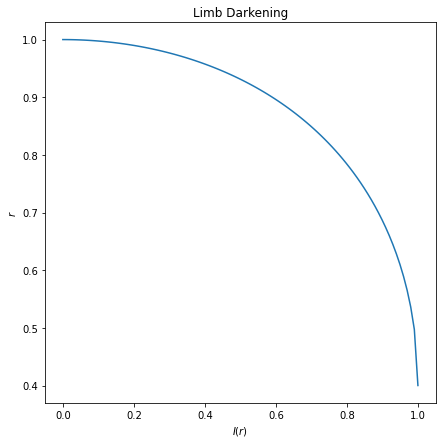

In [6]:
#Plot the limb-darkening function
plt.figure(figsize=(7,7))
plt.plot(r, I(r))
plt.title(r'Limb Darkening')
plt.xlabel(r'$I(r)$')
plt.ylabel(r'$r$')
plt.show()

---
## References


1. [astro-ph:0210099.pdf](https://arxiv.org/pdf/astro-ph/0210099.pdf).

2. [Modelling Exoplanets by D. Compton, D. Juncher and N. Vinyoles](https://phys.au.dk/fileadmin/Project_updated_gr.1.pdf)